## Goal: Predict employee retention and understand its main drivers

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Download Dateset

In [2]:
path = '/Users/shuyijiang1/Documents/DS Take Home/take home challenges/Employee Retention/employee_retention_data.csv'

with open(path, 'r') as file:
    df_origin = pd.read_csv(file)

In [3]:
df_origin.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021,7,customer_service,28,89000,2014-03-24,2015-10-30
1,825355,7,marketing,20,183000,2013-04-29,2014-04-04
2,927315,4,marketing,14,101000,2014-10-13,NaN
3,662910,7,customer_service,20,115000,2012-05-14,2013-06-07
4,256971,2,data_science,23,276000,2011-10-17,2014-08-22


In [4]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.5+ MB


In [5]:
df_origin.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


#### It looks like seniority has a maximum of 99 working years, let's look at the abnormal data and remove it.

In [6]:
df_origin.sort_values(by = 'seniority', ascending = False).head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
24701,604052,1,marketing,99,185000,2011-07-26,2013-12-06
24700,97289,10,engineer,98,266000,2011-12-13,2015-01-09
11717,426218,2,customer_service,29,118000,2011-03-02,2013-07-12
12013,889253,2,engineer,29,318000,2011-09-12,NaN
647,664204,8,marketing,29,147000,2014-02-03,2015-02-20


In [7]:
df_all = df_origin.loc[df_origin['seniority'] <= 30].copy()

In [8]:
df_all['join_date'] = pd.to_datetime(df_all['join_date'])
df_all['quit_date'] = pd.to_datetime(df_all['quit_date'])

In [9]:
# add quit or not flag
df_all['quit_flag'] = np.where(df_all['quit_date'].isnull(), 'N', 'Y')

In [10]:
# add working days before quitting if the employee quit
df_all['days_before_quit'] = np.where(df_all['quit_flag'] == 'Y', (df_all['quit_date'] - df_all['join_date']), np.nan)

# extract days from timedelta64 format
df_all['days_before_quit'] = df_all['days_before_quit']/ np.timedelta64(1, 'D') 

In [11]:
df_all.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_flag,days_before_quit
0,13021,7,customer_service,28,89000,2014-03-24,2015-10-30,Y,585
1,825355,7,marketing,20,183000,2013-04-29,2014-04-04,Y,340
2,927315,4,marketing,14,101000,2014-10-13,NaT,N,NaN
3,662910,7,customer_service,20,115000,2012-05-14,2013-06-07,Y,389
4,256971,2,data_science,23,276000,2011-10-17,2014-08-22,Y,1040


In [12]:
df_all.describe()

,employee_id,company_id,seniority,salary,days_before_quit
count,24700.000000,24700.000000,24700.000000,24700.000000,13508.000000
mean,501616.624899,3.426802,14.120972,138176.275304,613.430560
std,288908.533280,2.699752,8.054137,76056.331953,328.610626
min,36.000000,1.000000,1.000000,17000.000000,102.000000
25%,250165.250000,1.000000,7.000000,79000.000000,361.000000
50%,500793.000000,2.000000,14.000000,123000.000000,417.000000
75%,753142.250000,5.000000,21.000000,187000.000000,781.000000
max,999969.000000,12.000000,29.000000,408000.000000,1726.000000


## From company's perspective, create a table with day, current employees,  headcount available from 2011/01/24 to 2015/12/13.

In [13]:
df_all.head(3)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_flag,days_before_quit
0,13021,7,customer_service,28,89000,2014-03-24,2015-10-30,Y,585
1,825355,7,marketing,20,183000,2013-04-29,2014-04-04,Y,340
2,927315,4,marketing,14,101000,2014-10-13,NaT,N,NaN


In [14]:
date = np.unique(df_all[['join_date','quit_date']].values)

company = df_all['company_id'].unique()

In [15]:
df_company = pd.DataFrame(data = company, columns = ['company']).copy()

In [16]:
df_date = pd.DataFrame(data = date, columns = ['date']).copy()
df_date = df_date.loc[~df_date['date'].isnull()]

In [17]:
# add extra columns for outer joining
df_company['forjoin'] = 1
df_date['forjoin'] = 1

In [18]:
df_company = df_company.merge(df_date, how = 'outer', on = 'forjoin')

In [19]:
df_company.head(2)

,company,forjoin,date
0,7,1,2011-01-24
1,7,1,2011-01-25


#### Method 1: use pandasql

In [20]:
from pandasql import sqldf

In [21]:
query_base = """
select b.company,b.date, count(distinct employee_id) counts from df_company b
left join df_all a
on a.company_id = b.company and a.join_date<=b.date and (a.quit_date is null or b.date <a.quit_date)
group by 1,2
"""

In [22]:
query_quit = """
select b.company,b.date, count(distinct employee_id) counts from df_company b
left join df_all a
on a.company_id = b.company and  b.date >= a.quit_date
group by 1,2
"""

In [23]:
newdf = sqldf(query_base,locals())

In [24]:
quitdf = sqldf(query_quit,locals())

In [25]:
newdf.head(3)

,company,date,counts
0,1,2011-01-24 00:00:00.000000,25
1,1,2011-01-25 00:00:00.000000,27
2,1,2011-01-26 00:00:00.000000,29


In [26]:
quitdf.head(3)

,company,date,counts
0,1,2011-01-24 00:00:00.000000,0
1,1,2011-01-25 00:00:00.000000,0
2,1,2011-01-26 00:00:00.000000,0


In [27]:
companydf = newdf.merge(quitdf, how = 'left', on = ['company', 'date'])

In [28]:
companydf.head(3)

,company,date,counts_x,counts_y
0,1,2011-01-24 00:00:00.000000,25,0
1,1,2011-01-25 00:00:00.000000,27,0
2,1,2011-01-26 00:00:00.000000,29,0


In [202]:
companydf.loc[(companydf['company'] == 12) & (companydf['date'] == '2013-10-18 00:00:00.000000')]

,company,date,counts_x,counts_y
13751,12,2013-10-18 00:00:00.000000,8,7


In [29]:
companydf = companydf.rename(columns = {'counts_x': 'current_employee', 'counts_y': 'employee_headcount'})

In [30]:
companydf.head(3)

,company,date,current_employee,employee_headcount
0,1,2011-01-24 00:00:00.000000,25,0
1,1,2011-01-25 00:00:00.000000,27,0
2,1,2011-01-26 00:00:00.000000,29,0


#### Method 2: use pandas only ( Not correct for now)

In [96]:
# cumulative joined employee counts by date
company_join = df_all.groupby(['company_id', 'join_date'])['employee_id'].nunique().reset_index(name = 'counts')
company_join['cumulative_sum'] = company_join.groupby(['company_id'])['counts'].cumsum()

# cumulative quit employee counts by date
company_quit = df_all.groupby(['company_id', 'quit_date'])['employee_id'].nunique().reset_index(name = 'counts')
company_quit['cumulative_sum'] = company_quit.groupby(['company_id'])['counts'].cumsum()

In [129]:
df_company.head(3)

,company,forjoin,date
0,7,1,2011-01-24
1,7,1,2011-01-25
2,7,1,2011-01-26


In [180]:
df_company_2 = df_company.merge(company_join, how = 'left', left_on = ['company','date'], 
                                right_on = ['company_id','join_date']).copy()

In [181]:
df_company_2 = df_company_2.merge(company_quit, how = 'left', left_on = ['company','date'], 
                                right_on = ['company_id','quit_date'])

In [182]:
df_company_2 = df_company_2.loc[ ~ ((df_company_2['join_date'].isnull()) & (df_company_2['quit_date'].isnull()))]

In [186]:
col = ['cumulative_sum_x','cumulative_sum_y']
df_company_2[col] = df_company_2[col].fillna(0)

In [190]:
df_company_2.head(3)

,company,date,cumulative_sum_x,cumulative_sum_y,current_employee,employee_headcount
0,7,2011-01-24,1,0,1,0
3,7,2011-01-31,7,0,8,0
7,7,2011-02-07,12,0,20,0


In [184]:
df_company_2 = df_company_2.drop(['forjoin', 'company_id_x', 'company_id_y','counts_x', 'counts_y', 'join_date', 'quit_date'], axis=1) 

In [178]:
#df_company_2 = df_company_2.rename(columns = {'cumulative_sum_y':'employee_headcount'})

In [189]:
df_company_2['current_employee'] = df_company_2.groupby(['company'])['cumulative_sum_x'].cumsum()
df_company_2['employee_headcount'] = df_company_2.groupby(['company'])['cumulative_sum_y'].cumsum()

In [166]:
df_company_2.loc[(df_company_2['company'] == 1) & (df_company_2['date'] == '2011-01-26') ]

,company,date,join_date,cumulative_sum_x,quit_date,employee_headcount,current_employee
4766,1,2011-01-26,2011-01-26,29,NaT,0,29


In [162]:
col = ['cumulative_sum_x','employee_headcount']
df_company_2[col] = df_company_2[col].fillna(0)

In [164]:
df_company_2['current_employee'] = df_company_2['cumulative_sum_x'] - df_company_2['employee_headcount']

In [173]:
df_company_2 = df_company_2.loc[ ~ ((df_company_2['join_date'].isnull()) & (df_company_2['quit_date'].isnull()))]

,company,date,join_date,cumulative_sum_x,quit_date,employee_headcount,current_employee
0,7,2011-01-24,2011-01-24,1,NaT,0,1
3,7,2011-01-31,2011-01-31,7,NaT,0,7
7,7,2011-02-07,2011-02-07,12,NaT,0,12


#### Method 2: end

### Feature Enginerring

In [31]:
## dataset 1
df_all.head(3)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_flag,days_before_quit
0,13021,7,customer_service,28,89000,2014-03-24,2015-10-30,Y,585
1,825355,7,marketing,20,183000,2013-04-29,2014-04-04,Y,340
2,927315,4,marketing,14,101000,2014-10-13,NaT,N,NaN


In [32]:
### company dataset
companydf.head(3)

,company,date,current_employee,employee_headcount
0,1,2011-01-24 00:00:00.000000,25,0
1,1,2011-01-25 00:00:00.000000,27,0
2,1,2011-01-26 00:00:00.000000,29,0


#### 1. Company Info

In [33]:
company1 = df_all.groupby(['company_id'])['employee_id'].nunique().reset_index(name = 'total_employee')
company_quit_or_not = df_all.groupby(['company_id', 'quit_flag'])['employee_id'].nunique().reset_index(name = 'quit_employee')

In [34]:
company2 = company1.merge(company_quit_or_not.loc[company_quit_or_not['quit_flag'] == 'Y'], 
               how = 'left', on = 'company_id')

In [35]:
company2['quit_rate'] = company2['quit_employee']/company2['total_employee']

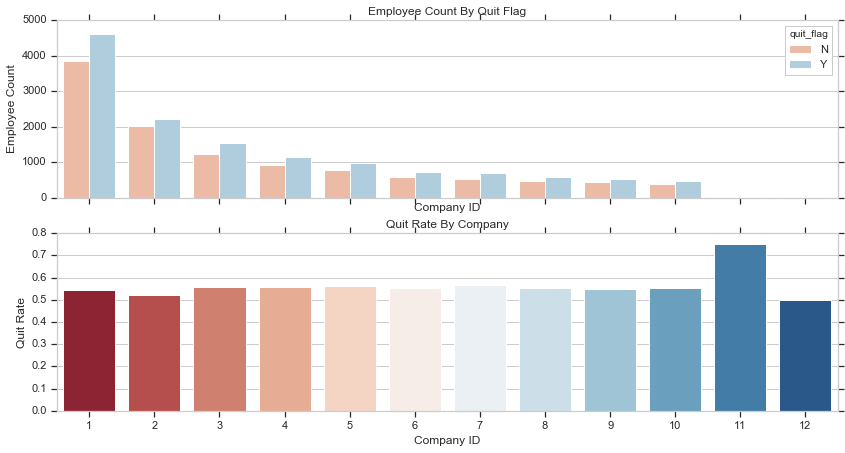

In [36]:
# bar chart by company
sns.set(style="whitegrid")

fig, axs = plt.subplots(2,1, sharex = True,  figsize=(14, 7))

f1 = sns.catplot(x = 'company_id', y = 'quit_employee', hue = 'quit_flag', kind = 'bar', 
            height = 3, aspect= 1, palette= "RdBu", data = company_quit_or_not, ax = axs[0])
axs[0].set_title('Employee Count By Quit Flag')
axs[0].set(xlabel='Company ID', ylabel='Employee Count')

f2 = sns.catplot(x = 'company_id', y = 'quit_rate',  kind = 'bar', height = 3, aspect= 1, 
                palette= "RdBu", data = company2, ax = axs[1])
axs[1].set_title('Quit Rate By Company')
axs[1].set(xlabel='Company ID', ylabel='Quit Rate')

plt.close(2)
plt.close(3)


##### All companies have a quit rate slightly larger than 0.5. Company 11 has a much higer quit rate, but they only have 16 employees so far while company 1 has nearly 9000.

In [37]:
companydf.head(3)

,company,date,current_employee,employee_headcount
0,1,2011-01-24 00:00:00.000000,25,0
1,1,2011-01-25 00:00:00.000000,27,0
2,1,2011-01-26 00:00:00.000000,29,0


In [38]:
companydf['date'] = companydf['date'].apply(lambda x: x[0:11])

In [39]:
from datetime import datetime
companydf['date_time'] = companydf['date']
companydf['date_time'] = companydf['date_time'].str.strip()
companydf['date_time'] = pd.to_datetime(companydf['date_time'], format = '%Y-%m-%d')

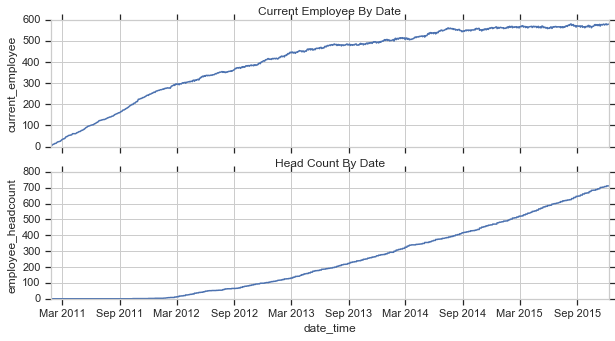

In [44]:
fig, axs = plt.subplots(2,1, sharex = True, figsize=(10, 5))
sns.lineplot(x = 'date_time', y = 'current_employee',
             data = companydf.loc[companydf['company'] == 6], 
             #data = companydf,
             ax = axs[0])

axs[0].set_title("Current Employee By Date")

sns.lineplot(x = 'date_time', y = 'employee_headcount',
             data = companydf.loc[companydf['company'] == 6], 
             #data = companydf,
             ax = axs[1])
axs[1].set_title("Head Count By Date")
plt.close(2)
plt.close(3)

#### 2. Department Info

In [46]:
df_all.head(2)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_flag,days_before_quit
0,13021,7,customer_service,28,89000,2014-03-24,2015-10-30,Y,585
1,825355,7,marketing,20,183000,2013-04-29,2014-04-04,Y,340


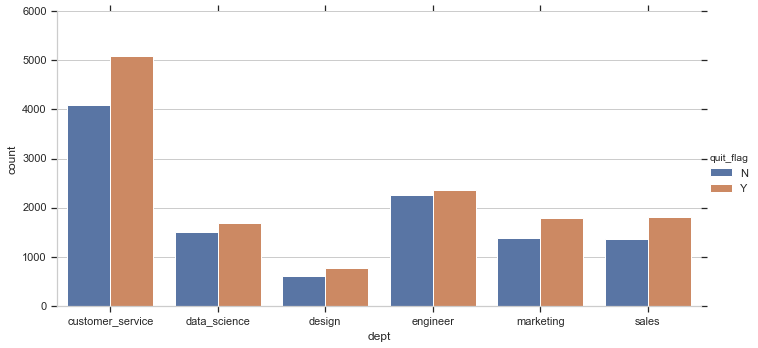

In [52]:
sns.catplot(x = 'dept', y = 'count', hue = 'quit_flag', kind = 'bar', height = 5, aspect= 2,
            data = df_all.groupby(['dept','quit_flag']).size().reset_index(name = 'count'))

In [57]:
dept_no = df_all[df_all['quit_flag'] == 'N'].groupby('dept')['employee_id'].size().reset_index(name = 'quit_no')
dept_yes = df_all[df_all['quit_flag'] == 'Y'].groupby('dept')['employee_id'].size().reset_index(name = 'quit_yes')

dept_cr = pd.merge(dept_no, dept_yes, how = 'inner', on = 'dept')

In [62]:
dept_cr.head(3)

,dept,quit_no,quit_yes,quit_rate
0,customer_service,4086,5094,0.554902
1,data_science,1508,1682,0.527273
2,design,602,778,0.563768


In [61]:
dept_cr['quit_rate'] = dept_cr['quit_yes']/(dept_cr['quit_no'] + dept_cr['quit_yes'])

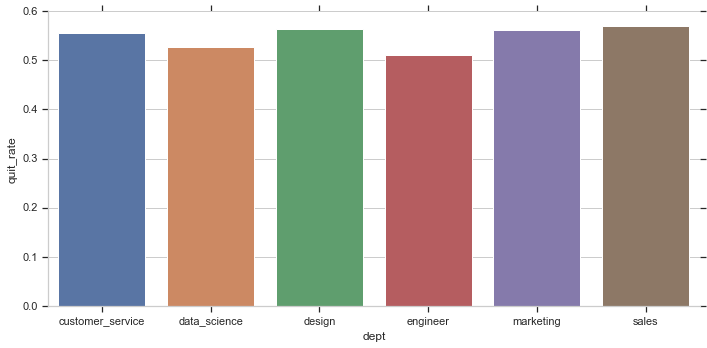

In [63]:
sns.catplot(x = 'dept', y = 'quit_rate', kind = 'bar', height = 5, aspect= 2,
            data = dept_cr)

#### 3. seniority Info

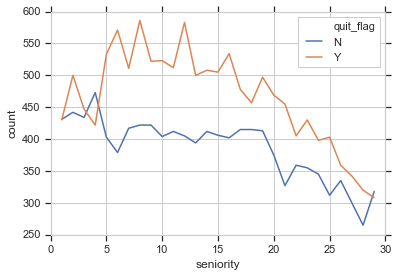

In [69]:
sns.lineplot(x = 'seniority', y = 'count', hue = 'quit_flag',
            data = df_all.groupby(['seniority','quit_flag']).size().reset_index(name = 'count'))

#### 4. salary	Info

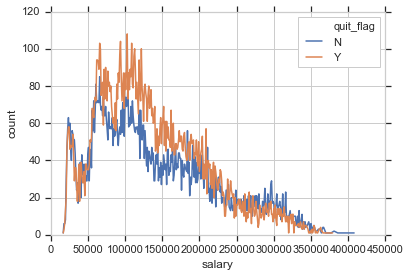

In [77]:
sns.lineplot(x = 'salary', y = 'count', hue = 'quit_flag',
            data = df_all.groupby(['salary','quit_flag']).size().reset_index(name = 'count'))

In [78]:
salary1 = df_all.groupby(['salary','quit_flag']).size().reset_index(name = 'count')

In [81]:
salary1.head(3)

,salary,quit_flag,count,group
0,17000,N,1,17000
1,17000,Y,1,17000
2,18000,N,6,17000


In [80]:
salary1['group'] = ((salary1['salary'] - 17000)//5000)*5000  + 17000 

In [82]:
salary1.groupby(['group','quit_flag'])['count'].sum().head(3)

group  quit_flag
17000  N             50
       Y             43
22000  N            281
Name: count, dtype: int64

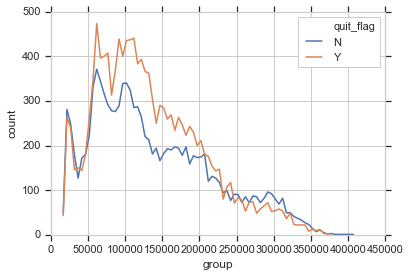

In [83]:
sns.lineplot(x = 'group', y = 'count', hue = 'quit_flag',
            data = salary1.groupby(['group','quit_flag'])['count'].sum().reset_index(name = 'count'))

In [88]:
salary_no = salary1[salary1['quit_flag'] == 'N'].groupby('group')['count'].sum().reset_index(name = 'quit_no')
salary_yes = salary1[salary1['quit_flag'] == 'Y'].groupby('group')['count'].sum().reset_index(name = 'quit_yes')

salary_cr = pd.merge(salary_no, salary_yes, how = 'inner', on = 'group')

In [90]:
salary_cr['quit_rate'] = salary_cr['quit_yes']/(salary_cr['quit_no'] + salary_cr['quit_yes'])

In [91]:
salary_cr.head(3)

,group,quit_no,quit_yes,quit_rate
0,17000,50,43,0.462366
1,22000,281,263,0.483456
2,27000,248,240,0.491803


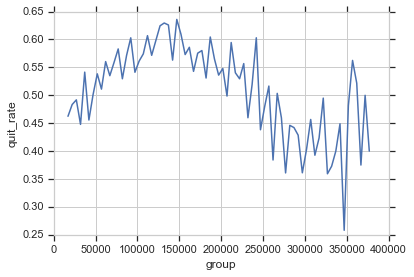

In [92]:
sns.lineplot(x = 'group', y = 'quit_rate', data = salary_cr)

#### 5. Days Before Quit

In [93]:
df_all.head(2)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_flag,days_before_quit
0,13021,7,customer_service,28,89000,2014-03-24,2015-10-30,Y,585
1,825355,7,marketing,20,183000,2013-04-29,2014-04-04,Y,340


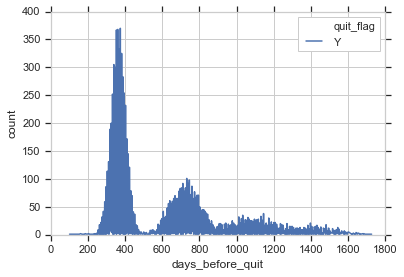

In [94]:
sns.lineplot(x = 'days_before_quit', y = 'count', hue = 'quit_flag',
            data = df_all.groupby(['days_before_quit','quit_flag']).size().reset_index(name = 'count'))

### Model

In [204]:
df_all.head(3) 

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_flag,days_before_quit,date,duration,salary_group
0,13021,7,customer_service,28,89000,2014-03-24,2015-10-30,Y,585,2011-01-24,1155,87000
1,825355,7,marketing,20,183000,2013-04-29,2014-04-04,Y,340,2011-01-24,826,182000
2,927315,4,marketing,14,101000,2014-10-13,NaT,N,NaN,2011-01-24,1358,97000


In [168]:
# add company's start time
df_all = df_all.merge(df_all.groupby('company_id')['join_date'].min().reset_index(name = 'date'),
                      how = 'left', on = 'company_id')

In [176]:
df_all['duration'] = (df_all['join_date'] - df_all['date'])
# remove days in the value
df_all['duration'] = df_all['duration'].dt.days

In [203]:
df_all['salary_group'] = ((df_all['salary'] - 17000)//5000)*5000  + 17000 

In [164]:
df_all.groupby('quit_flag').size()

quit_flag
N    11192
Y    13508
dtype: int64

In [205]:
df_x = df_all
df_y = df_all.iloc[:,6:8]

In [206]:
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.33)

In [98]:
import h2o

In [99]:
from h2o.estimators import H2ORandomForestEstimator

In [100]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_60"; Java(TM) SE Runtime Environment (build 1.8.0_60-b27); Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from /Users/shuyijiang1/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gp/1ptpfy4531xgwm6dnckgbn640000gp/T/tmpnzsrxtc8
  JVM stdout: /var/folders/gp/1ptpfy4531xgwm6dnckgbn640000gp/T/tmpnzsrxtc8/h2o_shuyijiang1_started_from_python.out
  JVM stderr: /var/folders/gp/1ptpfy4531xgwm6dnckgbn640000gp/T/tmpnzsrxtc8/h2o_shuyijiang1_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,20 hours and 18 minutes
H2O cluster name:,H2O_from_python_shuyijiang1_dx1fw8
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [129]:
mod = h2o.estimators.random_forest.H2ORandomForestEstimator()

In [207]:
train_data = h2o.H2OFrame(x_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [208]:
test_data = h2o.H2OFrame(x_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [187]:
"""
train_data['quit_flag']
train_data[0:6]
"""

"\ntrain_data['quit_flag']\ntrain_data[0:6]\n"

In [209]:
train_data.names

['employee_id',
 'company_id',
 'dept',
 'seniority',
 'salary',
 'join_date',
 'quit_date',
 'quit_flag',
 'days_before_quit',
 'date',
 'duration',
 'salary_group']

In [210]:
#clf.train(X, y, training_frame=train_data)
#col = ['employee_id','company_id','dept','seniority','salary','join_date']
col2 = ['company_id','dept','seniority','salary_group']
mod.train(x = col2, y = 'quit_flag', training_frame  = train_data)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [211]:
mod.model_performance()


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.2974561727225799
RMSE: 0.5453954278526544
LogLoss: 0.9537642358132287
Mean Per-Class Error: 0.49123006077015496
AUC: 0.5028224218588938
pr_auc: 0.5443691493237923
Gini: 0.005644843717787618
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


,N,Y,Error,Rate
N,0.0,7453.0,1.0,(7453.0/7453.0)
Y,0.0,9096.0,0.0,(0.0/9096.0)
Total,0.0,16549.0,0.4504,(7453.0/16549.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0,0.7093780,399.0
max f2,0.0,0.8591994,399.0
max f0point5,0.0724308,0.6049632,381.0
max accuracy,0.1084182,0.5521180,372.0
max precision,0.5311424,0.5573860,198.0
max recall,0.0,1.0,399.0
max specificity,1.0,0.9950356,0.0
max absolute_mcc,0.1084182,0.0325479,372.0
max min_per_class_accuracy,0.5638740,0.5022139,182.0
max mean_per_class_accuracy,0.5187727,0.5087699,204.0


Gains/Lift Table: Avg response rate: 54.96 %, avg score: 54.92 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100308,0.9717127,0.9206456,0.9206456,0.5060241,0.9896854,0.5060241,0.9896854,0.0092348,0.0092348,-7.9354357,-7.9354357
,2,0.0200012,0.9502328,0.9703313,0.9454134,0.5333333,0.9604404,0.5196375,0.9751071,0.0096746,0.0189094,-2.9668719,-5.4586592
,3,0.0304550,0.9333333,0.9885600,0.9602237,0.5433526,0.9414232,0.5277778,0.9635449,0.0103342,0.0292436,-1.1439952,-3.9776336
,4,0.0400024,0.9175943,0.9442306,0.9564066,0.5189873,0.9259424,0.5256798,0.9545703,0.0090150,0.0382586,-5.5769402,-4.3593412
,5,0.0500937,0.9047619,0.9260272,0.9502867,0.5089820,0.9104935,0.5223160,0.9456911,0.0093448,0.0476033,-7.3972767,-4.9713258
,6,0.1000060,0.8470180,0.9691565,0.9597045,0.5326877,0.8757778,0.5274924,0.9107978,0.0483729,0.0959763,-3.0843454,-4.0295459
,7,0.1500393,0.7990144,0.9558290,0.9584122,0.5253623,0.8214321,0.5267821,0.8809973,0.0478232,0.1437995,-4.4170953,-4.1587810
,8,0.2000121,0.7543907,1.0581832,0.9833399,0.5816203,0.7760383,0.5404834,0.8547734,0.0528804,0.1966799,5.8183222,-1.6660124
,9,0.3000181,0.6834422,1.0157698,0.9941498,0.5583082,0.7177452,0.5464250,0.8090973,0.1015831,0.2982630,1.5769755,-0.5850164
,10,0.4000242,0.6234378,1.0223657,1.0012038,0.5619335,0.6527369,0.5503021,0.7700072,0.1022427,0.4005057,2.2365663,0.1203793


In [212]:
pred = mod.predict(test_data)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [213]:
mod.model_performance(test_data)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.29446466543596844
RMSE: 0.5426459853679638
LogLoss: 0.8384376556684993
Mean Per-Class Error: 0.48930049753680604
AUC: 0.505965428478387
pr_auc: 0.539138345416065
Gini: 0.011930856956773983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.005397901892662049: 


,N,Y,Error,Rate
N,0.0,3739.0,1.0,(3739.0/3739.0)
Y,0.0,4412.0,0.0,(0.0/4412.0)
Total,0.0,8151.0,0.4587,(3739.0/8151.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0053979,0.7023800,399.0
max f2,0.0053979,0.8550719,399.0
max f0point5,0.0759524,0.5974497,382.0
max accuracy,0.1636302,0.5450865,355.0
max precision,0.9743125,0.6333333,5.0
max recall,0.0053979,1.0,399.0
max specificity,1.0,0.9991976,0.0
max absolute_mcc,0.0759524,0.0375854,382.0
max min_per_class_accuracy,0.5626946,0.5022665,185.0
max mean_per_class_accuracy,0.4840069,0.5106995,224.0


Gains/Lift Table: Avg response rate: 54.13 %, avg score: 55.06 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101828,0.9545742,0.8235672,0.8235672,0.4457831,0.9704617,0.4457831,0.9704617,0.0083862,0.0083862,-17.6432839,-17.6432839
,2,0.0207337,0.9370919,1.0526234,0.9401283,0.5697674,0.9440144,0.5088757,0.9570033,0.0111061,0.0194923,5.2623395,-5.9871679
,3,0.0300577,0.9223267,1.0209655,0.9652044,0.5526316,0.9299358,0.5224490,0.9486069,0.0095195,0.0290118,2.0965549,-3.4795641
,4,0.0404858,0.91,1.0215375,0.9797144,0.5529412,0.9159044,0.5303030,0.9401835,0.0106528,0.0396646,2.1537518,-2.0285585
,5,0.0500552,0.8975939,0.8289891,0.9508993,0.4487179,0.9032272,0.5147059,0.9331183,0.0079329,0.0475975,-17.1010879,-4.9100715
,6,0.1002331,0.8426033,0.9576084,0.9542579,0.5183374,0.8696009,0.5165239,0.9013207,0.0480508,0.0956482,-4.2391610,-4.5742057
,7,0.1501656,0.7951313,0.9986278,0.9690117,0.5405405,0.8182056,0.5245098,0.8736836,0.0498640,0.1455122,-0.1372179,-3.0988347
,8,0.2002208,0.7536411,0.9961802,0.9758038,0.5392157,0.7730666,0.5281863,0.8485293,0.0498640,0.1953762,-0.3819796,-2.4196210
,9,0.3000859,0.6847909,1.0417504,0.9977500,0.5638821,0.7185599,0.5400654,0.8052771,0.1040345,0.2994107,4.1750386,-0.2249959
,10,0.4000736,0.6208656,1.0427390,1.0089938,0.5644172,0.6532318,0.5461515,0.7672774,0.1042611,0.4036718,4.2738988,0.8993829


In [214]:
mod.varimp

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1555551409007_346


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.2974561727225799
RMSE: 0.5453954278526544
LogLoss: 0.9537642358132287
Mean Per-Class Error: 0.49123006077015496
AUC: 0.5028224218588938
pr_auc: 0.5443691493237923
Gini: 0.005644843717787618
Could not find exact threshold 0.0; using closest threshold found 0.0.
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0: 


,N,Y,Error,Rate
N,0.0,7453.0,1.0,(7453.0/7453.0)
Y,0.0,9096.0,0.0,(0.0/9096.0)
Total,0.0,16549.0,0.4504,(7453.0/16549.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0,0.7093780,399.0
max f2,0.0,0.8591994,399.0
max f0point5,0.0724308,0.6049632,381.0
max accuracy,0.1084182,0.5521180,372.0
max precision,0.5311424,0.5573860,198.0
max recall,0.0,1.0,399.0
max specificity,1.0,0.9950356,0.0
max absolute_mcc,0.1084182,0.0325479,372.0
max min_per_class_accuracy,0.5638740,0.5022139,182.0
max mean_per_class_accuracy,0.5187727,0.5087699,204.0


Gains/Lift Table: Avg response rate: 54.96 %, avg score: 54.92 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100308,0.9717127,0.9206456,0.9206456,0.5060241,0.9896854,0.5060241,0.9896854,0.0092348,0.0092348,-7.9354357,-7.9354357
,2,0.0200012,0.9502328,0.9703313,0.9454134,0.5333333,0.9604404,0.5196375,0.9751071,0.0096746,0.0189094,-2.9668719,-5.4586592
,3,0.0304550,0.9333333,0.9885600,0.9602237,0.5433526,0.9414232,0.5277778,0.9635449,0.0103342,0.0292436,-1.1439952,-3.9776336
,4,0.0400024,0.9175943,0.9442306,0.9564066,0.5189873,0.9259424,0.5256798,0.9545703,0.0090150,0.0382586,-5.5769402,-4.3593412
,5,0.0500937,0.9047619,0.9260272,0.9502867,0.5089820,0.9104935,0.5223160,0.9456911,0.0093448,0.0476033,-7.3972767,-4.9713258
,6,0.1000060,0.8470180,0.9691565,0.9597045,0.5326877,0.8757778,0.5274924,0.9107978,0.0483729,0.0959763,-3.0843454,-4.0295459
,7,0.1500393,0.7990144,0.9558290,0.9584122,0.5253623,0.8214321,0.5267821,0.8809973,0.0478232,0.1437995,-4.4170953,-4.1587810
,8,0.2000121,0.7543907,1.0581832,0.9833399,0.5816203,0.7760383,0.5404834,0.8547734,0.0528804,0.1966799,5.8183222,-1.6660124
,9,0.3000181,0.6834422,1.0157698,0.9941498,0.5583082,0.7177452,0.5464250,0.8090973,0.1015831,0.2982630,1.5769755,-0.5850164
,10,0.4000242,0.6234378,1.0223657,1.0012038,0.5619335,0.6527369,0.5503021,0.7700072,0.1022427,0.4005057,2.2365663,0.1203793



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-18 22:14:52,0.010 sec,0.0,nan,nan,nan,nan,nan,nan
,2019-04-18 22:14:52,0.108 sec,1.0,0.6096626,8.0458992,0.4983985,0.4135867,0.9803115,0.4516076
,2019-04-18 22:14:52,0.299 sec,2.0,0.6136982,8.2542101,0.4992366,0.4087699,0.9882916,0.4514802
,2019-04-18 22:14:52,0.482 sec,3.0,0.6083059,7.5898111,0.4986938,0.4181926,0.9933952,0.4512371
,2019-04-18 22:14:52,0.631 sec,4.0,0.5991961,6.6855945,0.5011248,0.4327327,0.9971849,0.4505983
---,---,---,---,---,---,---,---,---,---
,2019-04-18 22:14:56,3.858 sec,44.0,0.5463304,1.0008789,0.5025673,0.5437707,0.9535258,0.4503595
,2019-04-18 22:14:56,3.895 sec,45.0,0.5461000,0.9920908,0.5025617,0.5438828,0.9425658,0.4503595
,2019-04-18 22:14:56,3.932 sec,46.0,0.5457782,0.9797163,0.5027524,0.5440727,0.9425658,0.4503595
,2019-04-18 22:14:56,3.970 sec,47.0,0.5456708,0.9738334,0.5028712,0.5440824,0.9644859,0.4503595



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
salary_group,23328.4003906,1.0,0.3530383
seniority,22651.3085938,0.9709756,0.3427916
company_id,14680.0527344,0.6292782,0.2221593
dept,5419.1811523,0.2322997,0.0820107


<bound method ModelBase.varimp of >

#### sklearn

In [ ]:
"""
sklearn doesn't accept categorical variables.
Thus, one extra step to convert categorical to numerical values
"""


